# Churn Model
## Model: XGBoost Algorithm with Bayesian Optimization

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
churn = pd.read_csv('churn.csv', )
col_names = churn.columns.tolist()
print "number of features: ", len(col_names)
print col_names

number of features:  21
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [4]:
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
print "Should we drop the 'Phone' feature? ", len(churn["Phone"].unique()) == len(churn)

Should we drop the 'Phone' feature?  True


In [6]:
churn.drop("Phone", axis = 1, inplace=True)

In [7]:
churn_map = {"True.": 1, "False.": 0}
churn["Churn?"] = churn[["Churn?"]].applymap(lambda x: churn_map[x])

# Don't need the following if using tree based algorithms
plan_map = {"yes": 1, "no": 0}
churn["Int'l Plan"] = churn[["Int'l Plan"]].applymap(lambda x: plan_map[x])
churn["VMail Plan"] = churn[["VMail Plan"]].applymap(lambda x: plan_map[x])

In [8]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null int64
dtypes: float64(8), int64(11), object(1)
memory usage: 546.8+ KB


### Survival Analysis
Let's explore the survival curve. In our context, the survival is the churn rate (i.e. hen the phone subscriber leaves the service)

#### Survival function

Define an subsribers lifetime, defined as the time between when they first purchase the subsription and when they churned, as capital $T$. Let small $t$ represent number of days from when they were first subsribe that is, since there "birth". Then the survival function, $S(t)$, is defined as:

$$ S(t) = P(T > t ) $$

What is the probability that a randomly chosen individual from the population lasts longer than small t?

#### Kaplan-Meier estimate

IMO, the best way to estimate the survival function is using the Kaplan-Meier estimate. It's nonparametric, which means we don't assume the data follows any particular form:

$$\hat{S(t)} = \prod_{i=0}^t \left(1 - \frac{d_i}{n_i}\right), \;\; \text{for all $t$}$$

where $d_i$ are number of deaths at time $i$, and $n_i$ are the number of individuals in the population who are at risk of dieing (churn rate). Note that the above formula is for a specific $t$: if we compute this estimate over all $t$, then we get a curve.

This formula can be derived from the following logic:

$$P( T = 0 ) \approx \frac{d_0}{n_0}$$

$$ \Rightarrow P( T > 0 ) \approx \left(1 - \frac{d_0}{n_0} \right) $$

$$ P( T > 1 ) = P( T > 1 \;|\; T > 0 )P( T > 0 ) \\ \approx \left(1 - \frac{d_1}{n_1}\right)\left(1 - \frac{d_0}{n_0}\right)$$

and so on...

In [9]:
kmf = KaplanMeierFitter()

In [10]:
T = churn["Account Length"]
C = churn["Churn?"]
kmf.fit(T, event_observed=C )

<lifelines.KaplanMeierFitter: fitted with 3333 observations, 2850 censored>

## Plot Survival Curve

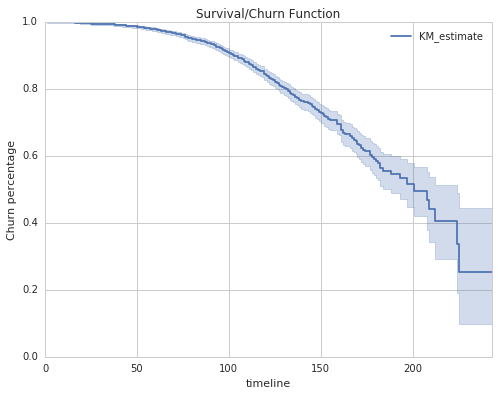

In [11]:
# average churn percentage per timeline
kmf.plot()
plt.title("Survival/Churn Function")
plt.ylabel("Churn percentage")
#sns.despine()
plt.show()

## Plot Survival Curve for Different States

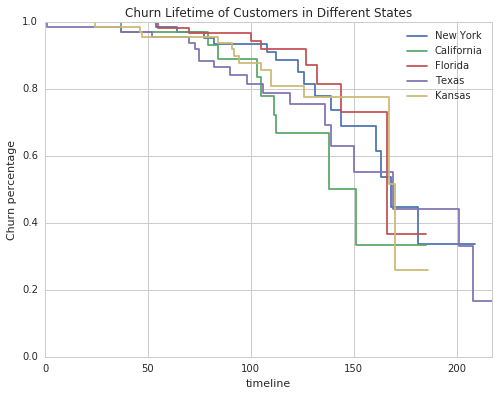

In [12]:
ax = plt.subplot(111)

state_list = [("NY", "New York"),
              ("CA", "California"),
              ("FL", "Florida"),
              ("TX", "Texas"),
              ("KS", "Kansas")]


for state, name in state_list:
    state_idx = churn["State"] == state
    kmf.fit(T[state_idx], event_observed=C[state_idx], label=name)
    kmf.plot(ax=ax, ci_show=False)

plt.ylim(0,1)
plt.ylabel("Churn percentage")
plt.title("Churn Lifetime of Customers in Different States")
plt.show()

In [13]:
print "Median user stay: ", kmf.median_

Median user stay:  170.0


In [14]:
#pd.pivot_table(churn, index=["Churn?"], aggfunc=[len])

In [15]:
# df1 = pd.DataFrame(churn["Churn?"], columns=["Churn?"])
# df1.rename(columns= {"Churn?":"Churn"}, inplace=True)

# reverse_map = {0:1, 1:0}
# df1["NotChurn"] = df1[["Churn"]].applymap(lambda x: reverse_map[x])

In [16]:
#sns.barplot(x = ["Churn", "NotChurn"],  data = df1)

## Imbalanced Classes

In [17]:
churn["Churn?"].mean()

0.14491449144914492

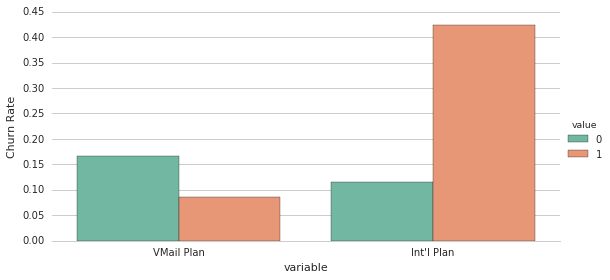

In [18]:
# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(churn, id_vars=['Churn?'], value_vars=["VMail Plan","Int'l Plan"], var_name='variable' )

# Create a factorplot
g = sns.factorplot( x="variable", y="Churn?", hue='value', data=df1, size=4, aspect=2, kind="bar", palette="Set2", ci=None )
g.despine(left=True)
g.set_ylabels("Churn Rate")
plt.show()

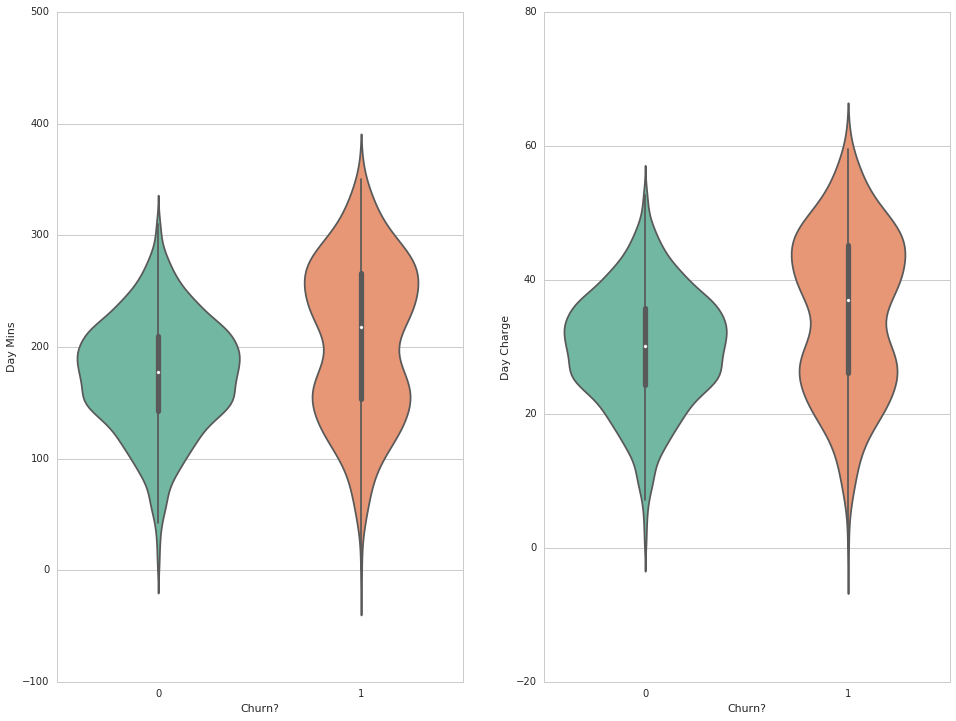

In [19]:
plt.figure(figsize=(16, 12))

for e, column in enumerate(['Day Mins','Day Charge']):
    plt.subplot(1, 2, e + 1)
    sns.violinplot( data=churn, x='Churn?', y=column, palette="Set2")

In [20]:
# churn['DayMin_Call'] = churn['Day Mins'] / churn['Day Calls']
# churn['EveMin_Call'] = churn['Eve Mins'] / churn['Eve Calls']
# churn['NightMinP_Call'] = churn['Night Mins'] / churn['Night Calls']
# churn['DayPrice_Min'] = churn['Day Charge'] / churn['Day Mins']
# churn['EvePrice_Min'] = churn['Eve Charge'] / churn['Eve Mins']
# churn['NightPrice_Min'] = churn['Night Charge'] / churn['Night Mins']

In [21]:
# new_features = ['DayMin_Call', 'EveMin_Call', 'NightMinP_Call', 'DayPrice_Min', 'EvePrice_Min', 'NightPrice_Min']
# for feature in new_features:
#     churn.loc[churn[feature].isnull(), feature] = 0

In [22]:
#churn['NoVMail Messages'] = np.where(churn['VMail Message'] < 1, "yes", "no")
churn['NoVMail Messages'] = np.where(churn['VMail Message'] < 1, 1, 0)

In [23]:
state = pd.read_csv('state_latlon.csv')
pvtable = churn.pivot_table(index='State', values='Churn?', aggfunc=[len, np.sum, np.mean, np.std] )
print pvtable.head()

       len  sum      mean       std
State                              
AK      52    3  0.057692  0.235435
AL      80    8  0.100000  0.301893
AR      55   11  0.200000  0.403687
AZ      64    4  0.062500  0.243975
CA      34    9  0.264706  0.447811


In [24]:
state_merged = pd.merge(pvtable,state,left_index=True,right_on='state')
print state_merged.head(2)

   len  sum      mean       std state  latitude  longitude
0   52    3  0.057692  0.235435    AK    61.385  -152.2683
1   80    8  0.100000  0.301893    AL    32.799   -86.8073


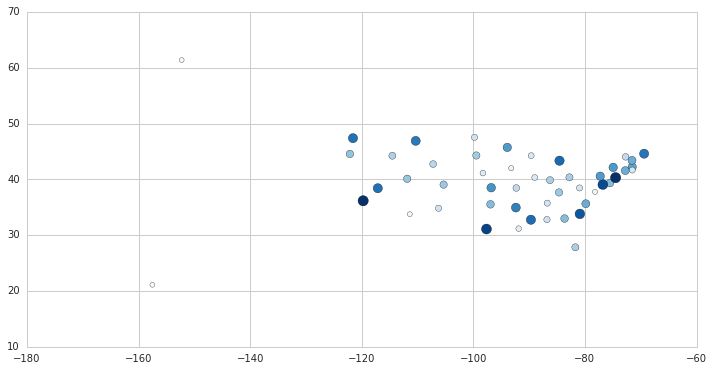

In [25]:
plt.figure(figsize=(12,6))
plt.scatter(
    x=state_merged.longitude,
    y=state_merged.latitude,
    s=state_merged['mean']*20**2,
    c=state_merged['mean'],
    cmap=plt.get_cmap('Blues')
)
pass

In [26]:
churn["latitude"] = churn[["State"]].applymap(lambda x: state[state["state"] == x]["latitude"].values[0])
churn["longitude"] = churn[["State"]].applymap(lambda x: state[state["state"] == x]["longitude"].values[0])

In [27]:
churn.drop("State", axis=1, inplace=True)

In [31]:
from sklearn.preprocessing import PolynomialFeatures
no_poly_features = ["Int'l Plan", "VMail Plan", "NoVMail Messages", "Area Code"]

churn_poly = churn.drop(no_poly_features + ["Churn?"], axis=1, inplace=False)

poly = PolynomialFeatures(degree = 2, include_bias=False)
churn_poly_arr = poly.fit_transform(churn_poly.values)

print "New data dimensions: ", churn_poly_arr.shape

poly_df = pd.DataFrame(churn_poly_arr)
full_churn = poly_df.join(churn[no_poly_features])

New data dimensions:  (3333, 170)


In [33]:
y = churn["Churn?"].values

#churn.drop("Churn?", axis=1, inplace=True)

#X = churn.values
#X = churn_cont_arr
X = full_churn.values

In [34]:
X[0,:]

array([  1.28000000e+02,   2.50000000e+01,   2.65100000e+02,
         1.10000000e+02,   4.50700000e+01,   1.97400000e+02,
         9.90000000e+01,   1.67800000e+01,   2.44700000e+02,
         9.10000000e+01,   1.10100000e+01,   1.00000000e+01,
         3.00000000e+00,   2.70000000e+00,   1.00000000e+00,
         3.85111000e+01,  -9.68005000e+01,   1.63840000e+04,
         3.20000000e+03,   3.39328000e+04,   1.40800000e+04,
         5.76896000e+03,   2.52672000e+04,   1.26720000e+04,
         2.14784000e+03,   3.13216000e+04,   1.16480000e+04,
         1.40928000e+03,   1.28000000e+03,   3.84000000e+02,
         3.45600000e+02,   1.28000000e+02,   4.92942080e+03,
        -1.23904640e+04,   6.25000000e+02,   6.62750000e+03,
         2.75000000e+03,   1.12675000e+03,   4.93500000e+03,
         2.47500000e+03,   4.19500000e+02,   6.11750000e+03,
         2.27500000e+03,   2.75250000e+02,   2.50000000e+02,
         7.50000000e+01,   6.75000000e+01,   2.50000000e+01,
         9.62777500e+02,

## XGBoost Cross Validation

In [35]:
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

In [36]:
#train = X[:,1:]
train = X
labels = y

In [37]:
def xgboostcv(max_depth,
              learning_rate,
              n_estimators,
              gamma,
              min_child_weight,
              max_delta_step,
              subsample,
              colsample_bytree,
              silent =True,
              nthread = -1,
              seed = 1234):
    return cross_val_score(XGBClassifier(max_depth = int(max_depth),
                                         learning_rate = learning_rate,
                                         n_estimators = int(n_estimators),
                                         silent = silent,
                                         nthread = nthread,
                                         gamma = gamma,
                                         min_child_weight = min_child_weight,
                                         max_delta_step = max_delta_step,
                                         subsample = subsample,
                                         colsample_bytree = colsample_bytree,
                                         seed = seed,
                                         objective = "binary:logistic"),
                           train,
                           labels,
                           "f1",
                           cv=5).mean()

## Bayesian Optimization for Parameter Tuning

In [38]:
xgboostBO = BayesianOptimization(xgboostcv,
                                     {'max_depth': (3, 30),
                                      'learning_rate': (0.01, 0.5),
                                      'n_estimators': (90, 800),
                                      'gamma': (100., 0.1),
                                      'min_child_weight': (1, 10),
                                      'max_delta_step': (0, 3),
                                      'subsample': (0.7, 0.8),
                                      'colsample_bytree' :(0.4, 0.99)
                                     })

In [39]:
xgboostBO.maximize()
print('-'*53)

print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_delta_step |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 00m23s |    0.32754 |             0.9298 |   97.1978 |          0.4157 |           2.3124 |     24.8096 |             2.4175 |       586.0870 |      0.7072 | 
    2 | 00m09s |    0.34846 |             0.5933 |   77.2305 |          0.2350 |           2.0030 |     18.4199 |             7.1518 |       442.1999 |      0.7468 | 
    3 | 00m08s |    0.83645 |             0.7521 |    7.0613 |          0.2638 |           1.7833 |      9.0954 |             5.7450 |       498.1115 |      0.7614 | 
    4 | 00m04s |    0.82741 |             0.5398 |    4.0394 |          0.0371 |           2.9132 |     19.0508 |             9.0460 |       338.4286 |

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    6 | 00m27s |    0.00000 |             0.9562 |  100.0000 |          0.2949 |           0.2559 |     17.6053 |             8.2168 |        97.9027 |      0.7096 | 
    7 | 00m20s |    0.11049 |             0.7478 |  100.0000 |          0.4016 |           0.7303 |      6.3801 |             3.6448 |       470.8766 |      0.7130 | 
    8 | 00m27s |    0.31901 |             0.8010 |  100.0000 |          0.4397 |           2.6230 |     22.4189 |             7.6215 |       738.7536 |      0.7661 | 
    9 | 00m34s |    0.04377 |             0.9141 |  100.0000 |          0.1696 |           1.2846 |     24.0258 |             4.4261 |       646.2551 |      0.7119 | 
   10 | 00m23s |    0.13277 |             0.5411 |  100.0000 |          0.1760 |           1.8979 |     26.1963 |             4.3721 |       661.0980 |      0.7683 | 
   11 | 00m22s |    0.09166 |             0.6193 |  100.0000 |          0.1908 |           2.7531 |     17.7388 |             1.7289 |       244.9996 |      0.7377 |

In [40]:
params = xgboostBO.res["max"]["max_params"]

print "F1 Score: ", xgboostBO.res['max']['max_val']
params

F1 Score:  0.836453754787


{'colsample_bytree': 0.75206244581274062,
 'gamma': 7.0613136780964112,
 'learning_rate': 0.26381323754962049,
 'max_delta_step': 1.7832654725180621,
 'max_depth': 9.0953808606979738,
 'min_child_weight': 5.745023066165369,
 'n_estimators': 498.11153445322185,
 'subsample': 0.76138772190241055}

In [ ]:
#xgboostcv(**params)
# F1: 0.82786420719981924
# F1: 0.837533